In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, logPr

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from true_distribution import generate_Xs, generate_Xsamples

Mean and covariance of X

In [3]:
def mean_X(nk):
    return np.cumprod(nk/(nk+1))

def cov_X(nk):
    t_1 = np.cumprod(nk/(nk+1)) # cumulative product of expectation of t
    t_2 = np.cumprod(nk/(nk+2)) # cumulative product of expectation of t^2
    iterations = len(nk)
    cov_X = np.zeros((iterations, iterations))
    for i in range(iterations):
        cov_X[i][i] = t_2[i] - t_1[i]**2 
        for j in range(i+1, iterations): # start j above i so min(i,j) automatically fulfilled
            correlated = t_2[i] - t_1[i]**2
            independent = t_1[j]/t_1[i] # cumulative product from i+1 to j
            cov_X[i][j] = cov_X[j][i] = correlated * independent
    return cov_X

In [4]:
def data_at_iteration(samples, iteration):
    points = points_at_iteration(samples, iteration)
    nk = np.array(points.nlive)
    logL = np.array(points.logL)
    return nk, logL 

1. Define a live point distribution, from which we get $\mu(X_i)$, $\mathrm{Cov}(X_i, X_j)$

2. Generate a set of $\bm{X}$ across a run using $\Pr(t) = n t^{n-1}$

3. Calculate $\log L = -X^{2/d}$, which is the data

4. Try to infer $d$ from $\log L$ and known $\mu$, $\mathrm{Cov}$

##### Functions

In [5]:
def logL_X(X, theta):
    d = theta
    return - X**(2/d)

def X_logL(logL, theta):
    d = theta
    return np.exp(d/2 * np.log(-logL))

def minimize_theta(logL, mean, cov_inv, x0):
    def func(theta):
        X = X_logL(logL, theta)
        return (X - mean).T @ cov_inv @ (X - mean) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

def pr_d(logL, mean, covinv, d):
    X = X_logL(logL, d)
    pr = - (X - mean).T @ covinv @ (X - mean)
    return pr
    
def plot_pr_d(logL, mean, covinv):
    ds = np.linspace(0, 20, 50)
    prs = np.zeros_like(ds)
    for i, d in enumerate(ds):
        prs[i] = pr_d(logL, mean, covinv, d)
    plt.plot(ds, prs, color='blue', label='X')
    dmax = ds[np.argmax(prs)]
    plt.axvline(x=dmax, ls='--', lw=1, color='blue')
    print(f"X: {dmax:.3f}")

In [6]:
def logL_logX(logX, theta):
    d = theta
    X = np.exp(logX)
    return - X**(2/d)

def logX_logL(logL, theta):
    d = theta
    return d/2 * np.log(-logL)

def minimize_theta_logX(logL, mean, cov_inv, x0):
    def func(theta):
        logX = logX_logL(logL, theta)
        return (logX - mean).T @ cov_inv @ (logX - mean) # want to maximise probability <-> minimise negative
    solution = minimize(func, x0)
    return solution

def pr_d_logX(logL, mean, covinv, d):
    logX = logX_logL(logL, d)
    pr = - (logX - mean).T @ covinv @ (logX - mean)
    return pr
    
def plot_pr_d_logX(logL, mean, covinv):
    ds = np.linspace(0, 20, 50)
    prs = np.zeros_like(ds)
    for i, d in enumerate(ds):
        prs[i] = pr_d_logX(logL, mean, covinv, d)
    plt.plot(ds, prs, color='red', label='logX')
    dmax = ds[np.argmax(prs)]
    plt.axvline(x=dmax, ls='--', lw=1, color='red')
    print(f"logX: {dmax:.3f}")

#### **Results**

Lack of sharp maximum for Gaussian

X maximum moves when number of points increases, logX maximum remains stable

In [298]:
iteration = 2000
nk = data_at_iteration(samples_g_1, iteration)[0][:iteration]

meanX = mean_X(nk)
covX = cov_X(nk)
covinvX = np.linalg.inv(covX)

meanlogX = logX_mu(nk)
covinvlogX = logX_covinv_chol(nk)

In [321]:
Xs = generate_Xs(nk)
d_true = 10
logL = logL_X(Xs, d_true)

X: 15.510
logX: 4.898


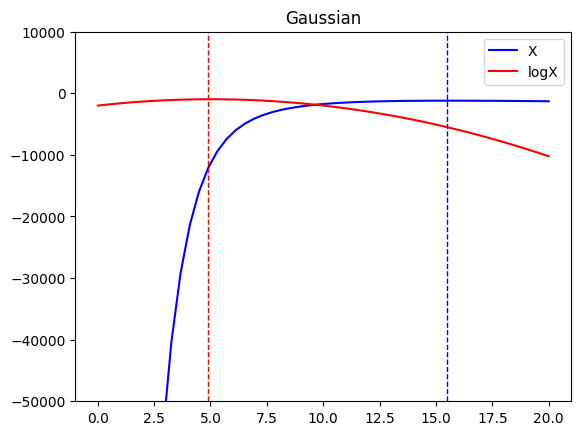

In [322]:
plot_pr_d(logL, meanX, covinvX)
plot_pr_d_logX(logL, meanlogX, covinvlogX)
plt.ylim(-50000,10000)
plt.title('Gaussian')
plt.legend();

X: 9.796
logX: 9.796


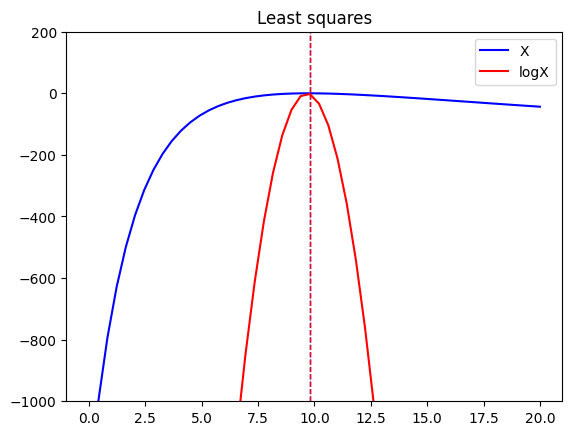

In [326]:
plot_pr_d(logL, meanX, np.eye(len(meanX)))
plot_pr_d_logX(logL, meanlogX, np.eye(len(meanlogX)))
plt.ylim(-1000, 200)
plt.title('Least squares')
plt.legend();

#### Slider

In [7]:
from ipywidgets import interact
import ipywidgets as widgets

In [9]:
%matplotlib

Using matplotlib backend: TkAgg


In [10]:
@interact(iterations=widgets.IntSlider(min=100, max=1500, step=100))
def nk_sliders(iterations):
        plt.clf()
        nk = 500 * np.ones(iterations)
        meanX = mean_X(nk)
        covX = cov_X(nk)
        covinvX = np.linalg.inv(covX)

        meanlogX = logX_mu(nk)
        covinvlogX = logX_covinv_chol(nk)

        Xs = generate_Xs(nk)
        d_true = 10
        logL = logL_X(Xs, d_true)

        plot_pr_d(logL, meanX, covinvX)
        plot_pr_d_logX(logL, meanlogX, covinvlogX)
        plt.ylim(-50000,10000)
        plt.title('Gaussian')
        plt.legend();

interactive(children=(IntSlider(value=100, description='iterations', max=1500, min=100, step=100), Output()), …